In [29]:
import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.color
import skimage.filters
import skimage.io
import skimage.measure
import skimage.morphology

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

Load input image

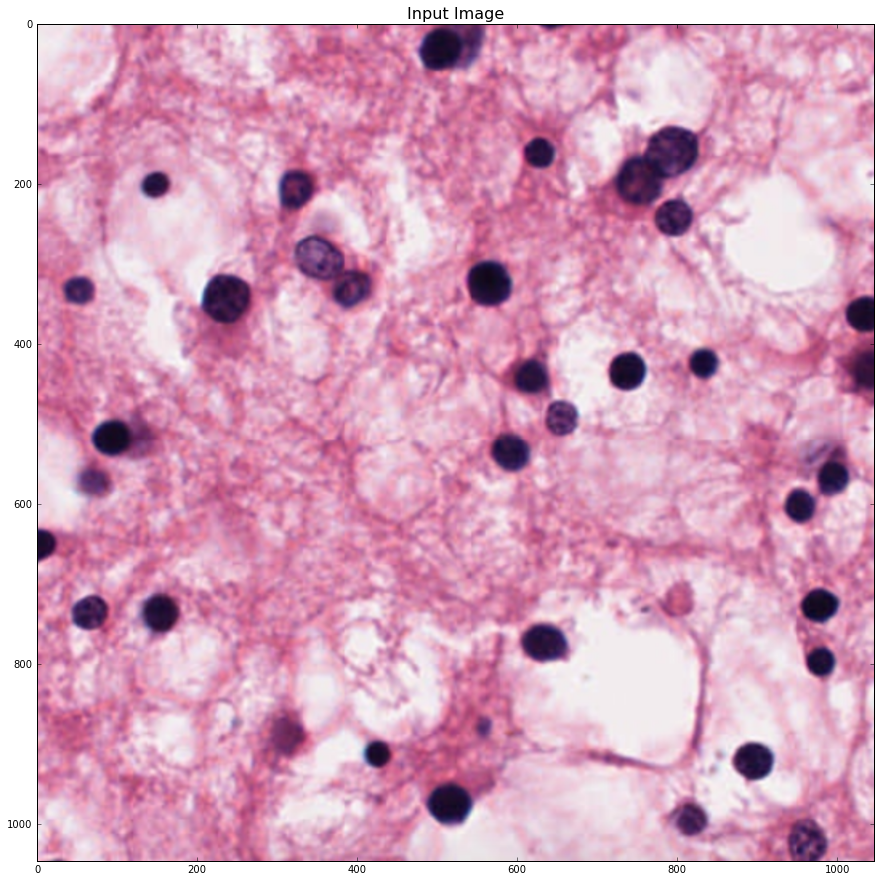

In [30]:
inputImageFile = ('https://data.kitware.com/api/v1/file/'
                  '576ad39b8d777f1ecd6702f2/download')  # Membrane.png

im_input = skimage.io.imread(inputImageFile)[:, :, :3]
sizemin = min(im_input.shape[0], im_input.shape[1])
im_input = im_input[0:sizemin, 0:sizemin, :]

plt.imshow(im_input)
_ = plt.title('Input Image', fontsize=16)

Perform color deconvolution

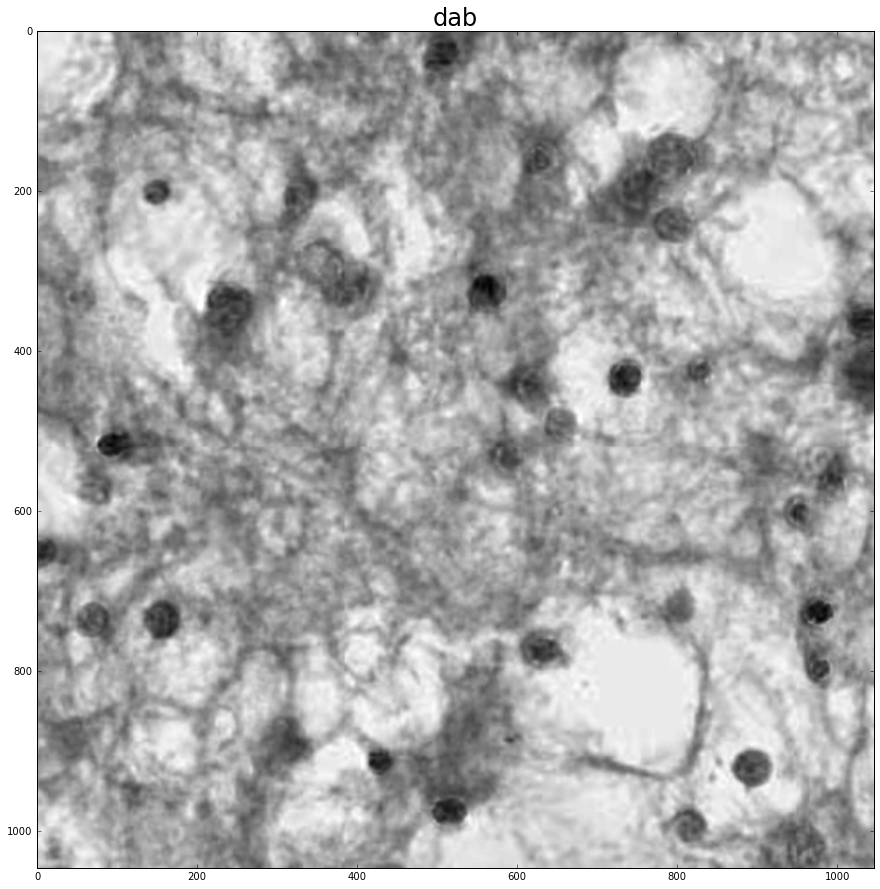

In [31]:
# create stain to color map
stainColorMap = {
    'hematoxylin': [0.65, 0.70, 0.29],
    'eosin':       [0.07, 0.99, 0.11],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.0, 0.0, 0.0]
}

# specify stains of input image
stain_1 = 'hematoxylin'   # nuclei stain
stain_2 = 'eosin'         # cytoplasm stain
stain_3 = 'dab'          # membrane stain

# create stain matrix
W = np.array([stainColorMap[stain_1], 
              stainColorMap[stain_2], 
              stainColorMap[stain_3]]).T

# perform standard color deconvolution
im_deconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(im_input, W)

# get dab channel
im_membrane_stain = im_deconvolved.Stains[:, :, 2].astype(np.float)

# Display results
plt.figure()
plt.imshow(im_deconvolved.Stains[:, :, 2])
_ = plt.title(stain_3, fontsize=titlesize)

Perform image enhancement

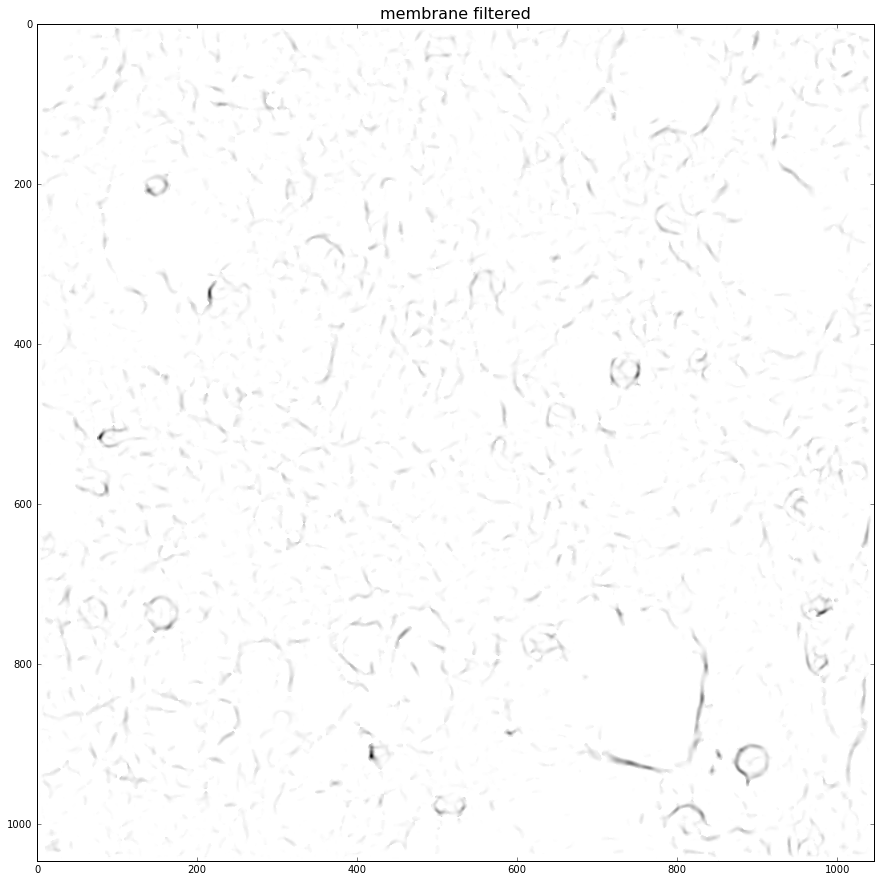

In [32]:
# membrane filtering
deviation, thetas = htk.filters.shape.membranefilter(
    im_membrane_stain, [1, 2, 3], 4, 2
)
deviation = 255 * deviation / deviation.max()
im_membranefiltered = 255-(255 * deviation / deviation.max())

plt.imshow(im_membranefiltered)
_ = plt.title('membrane filtered', fontsize=16)

In [33]:
# segmentation
im_mask = deviation > 0.4 * skimage.filters.threshold_otsu(deviation)
im_opened = sp.ndimage.binary_opening(
    im_mask, structure=np.ones((3, 3))
).astype(np.int)
# skeletonization
im_skeleton = skimage.morphology.skeletonize(im_opened)


Perform membrane label detection

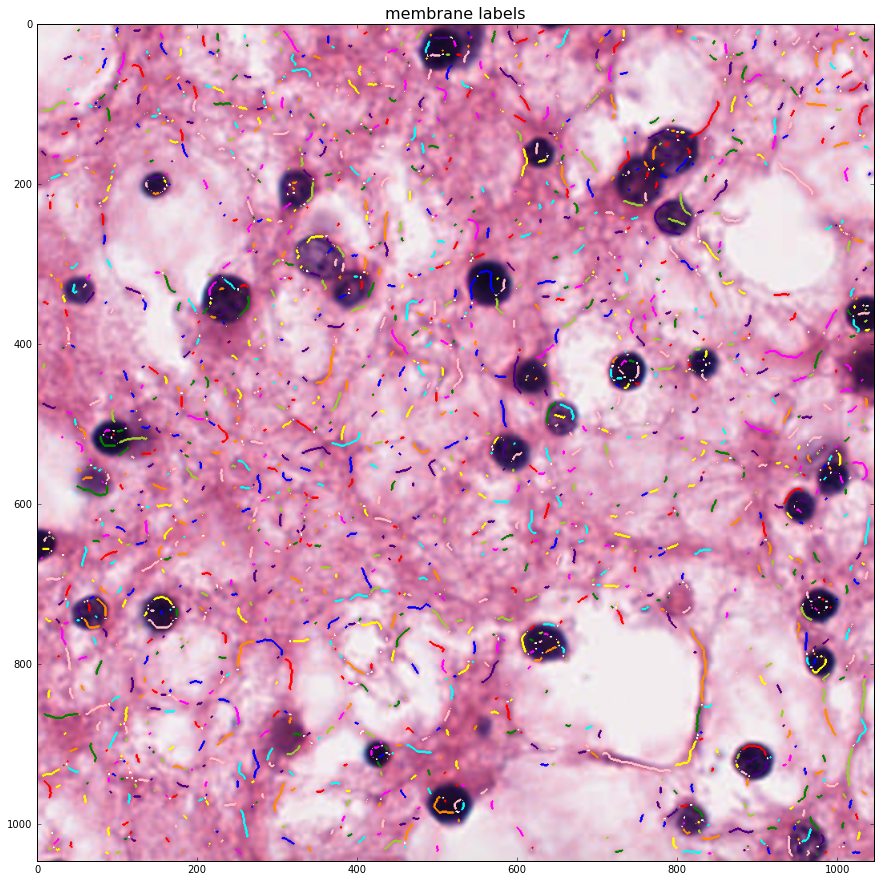

In [34]:
# set default branch mask
branch_mask = np.ones((3, 3))

# perform convolution
im_branch_mask = sp.signal.convolve2d(
    im_skeleton, branch_mask, boundary='wrap', mode='same'
)

im_branches = np.zeros_like(im_branch_mask)
im_branches[np.where(im_branch_mask > 3)] = 1

# label detection
im_split = im_skeleton & ~sp.ndimage.binary_dilation(
    im_branches,
    structure=skimage.morphology.disk(3)
)
im_split = sp.ndimage.binary_dilation(
    im_split,
    structure=skimage.morphology.disk(1)
)

# get labeled arrays
labeled_array, num_features = sp.ndimage.label(im_split)

# get labels
im_label = skimage.color.label2rgb(labeled_array)
im_label = 255 * im_label / im_label.max()

# get x and y points of intersection between branches
px, py = np.where(im_branches > 0)

# membrane color rendering
split_points = np.where(im_split > 0)

red = im_input[:, :, 0]
lred = im_label[:, :, 0]
red[split_points] = lred[split_points]
green = im_input[:, :, 1]
lgreen = im_label[:, :, 1]
green[split_points] = lgreen[split_points]
blue = im_input[:, :, 2]
lblue = im_label[:, :, 2]
blue[split_points] = lblue[split_points]

# generate membrane labeled image
im_membraned_color = np.concatenate(
    (red[..., np.newaxis], green[..., np.newaxis], blue[..., np.newaxis]),
    axis=2
)
im_membraned_color[px, py, :] = 255

# Display results
plt.figure()
plt.imshow(im_membraned_color)
_ = plt.title('membrane labels', fontsize=16)